In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)
import tqdm

Relu neurons

In [2]:
d = 50 # dimension of space
M = 10 # number of neurons for generation

In [3]:
def relu(x):
    if x >= 0:
        return x
    return 0

In [0]:
def drelu(x):
    if x >= 0:
        return 1
    return 0

In [0]:
class Neuron:
    def __init__(self):
        a = np.random.normal()
        w = np.random.normal(size = d)
        b = np.random.normal()
        #norm = 1e-1 * np.linalg.norm(np.concatenate([np.array([a, b]), w]), 2)
        self.a = a # / norm
        self.w = w #/ norm
        self.b = b #/ norm
    def set_weights(self, a, w, b):
        self.a = a
        self.w = w
        self.b = b
    def forward(self, x):
        return self.a * relu(self.w.dot(x) + self.b)

In [0]:
class Network:
    def __init__(self, width):
        self.width = width
        self.neurons = [Neuron() for i in range(width)]
    def small_sphere(self, R):
        for nr in self.neurons:
            norm = 1./R * np.linalg.norm(np.concatenate([np.array([nr.b]), nr.w]), 2)
            nr.set_weights(nr.a, nr.w/norm, nr.b/norm)
        return
    def output(self, x):
        return np.mean([n.forward(x) for n in self.neurons])
    def loss(self, x, y):
        return .5*(self.output(x) - y)**2
    def grad(self, x, y):
        d = (self.output(x) - y)
        s = np.array([relu(n.w.dot(x) + n.b) for n in self.neurons])
        ds = np.array([drelu(n.w.dot(x) + n.b) for n in self.neurons])
        ga = 1./self.width * d * s
        gb = 1./self.width * d * np.array([self.neurons[i].a*ds[i] for i in range(self.width)])
        gw = np.array([gb[i] * x for i in range(self.width)]) # shape m * d
        return ga, gw, gb
    def step(self, x, y, tau):
        ga, gw, gb = self.grad(x, y)
        for i in range(self.width):
            nr = self.neurons[i]
            a_new = nr.a - tau * ga[i]
            w_new = nr.w - tau * gw[i]
            b_new = nr.b - tau * gb[i]
            nr.set_weights(a_new, w_new, b_new)
    def batch_step(self, X, Y, tau):
        ba = X.shape[0]
        Ga, Gw, Gb = np.zeros((ba, self.width)), np.zeros((ba, self.width, d)), np.zeros((ba, self.width))
        for i in range(ba):
            Ga[i], Gw[i], Gb[i] = self.grad(X[i], Y[i])
        ga, gw, gb = Ga.mean(axis = 0), Gw.mean(axis = 0), Gb.mean(axis = 0)
        for i in range(self.width):
            nr = self.neurons[i]
            a_new = nr.a - tau * ga[i]
            w_new = nr.w - tau * gw[i]
            b_new = nr.b - tau * gb[i]
            nr.set_weights(a_new, w_new, b_new)
    def sgd_train(self, X, Y, tau, epochs, batch, disp = True):
        for e in range(epochs):
            pm = np.random.permutation(X.shape[0])
            X = np.array([X[pm[i]] for i in range(X.shape[0])])
            Y = np.array([Y[pm[i]] for i in range(Y.shape[0])])
            if batch > 1:
                nbatch = X.shape[0]//batch
                subX = np.split(X, nbatch)
                subY = np.split(Y, nbatch)
                for s in range(len(subX)):
                    self.batch_step(subX[s], subY[s], tau)
            else:
                for i in range(X.shape[0]):
                    self.step(X[i], Y[i], tau)
            loss = self.test(X, Y)
            if disp:
                print('epoch '+str(e)+' : '+str(loss))
        return loss
    def test(self, X_t, Y_t):
        ts = X_t.shape[0]
        return np.mean([self.loss(X_t[i], Y_t[i]) for i in range(ts)])
    def gen_sample(self, s = 1):
        if s==1:
            X = np.random.normal(size = d)
            Y = self.output(X)
            return X, Y
        else:
            X = np.random.normal(size = (s, d))
            Y = np.zeros(s)
            for i in range(s):
                Y[i] = self.output(X[i])
            return X, Y
    def give_weights(self):
        la, lw, lb = np.zeros(self.width), np.zeros((self.width, d)), np.zeros(self.width)
        for i in range(self.width):
            nr = self.neurons[i]
            la[i] = nr.a
            lw[i] = nr.w
            lb[i] = nr.b
        return la, lw, lb
    def display_weights(self, fig, ax, scat = None, true_w = None, color='b'):
        assert d==2, 'must be in dimension 2'
        #ax.cla()
        ax.set_xlim((-2, 2))
        ax.set_ylim((-2, 2))
        la, lw, _ = self.give_weights()
        x, y = np.zeros(self.width), np.zeros(self.width)
        for k in range(self.width):
            x[k] = lw[k, 0] * la[k]
            y[k] = lw[k, 1] * la[k] 
        if scat is None:
            pos = ax.scatter(x, y, s = 10., color=color)
        else:
            scat.set_offsets(np.array([x, y]).T)
            trace = ax.scatter(x, y, s = 5., color='grey', alpha = 0.4)
        if true_w is not None:
            tla, tlw, tlb = true_w
            tx, ty = np.zeros(tla.shape[0]), np.zeros(tla.shape[0])
            for k in range(tla.shape[0]):
                tx[k] = tlw[k, 0] * tla[k]
                ty[k] = tlw[k, 1] * tla[k]
                if tx[k]>= 0:
                    u = np.linspace(0., 2., 10)
                else:
                    u = np.linspace(-2., 0., 10)
                v = ty[k]/tx[k] * u
                ax.plot(u, v, color = 'k')
            ax.scatter(tx, ty, s = 100., color='r', alpha = 0.4)
                
        if scat is None:
            fig.canvas.draw()
        

In [0]:
gen_net = Network(M)
gen_net.small_sphere(2.)

X_test, Y_test = gen_net.gen_sample(10000)

Initialize new network with parameters on the sphere.

In [0]:
net = Network(20)
net.small_sphere(0.05)

test_loss = []
train_loss = []
test = net.test(X_test, Y_test)
print('init', test)
for i in range(5000):
    X, Y = gen_net.gen_sample(100)
    net.sgd_train(X, Y, tau = .5, batch = 1, epochs = 1, disp = False)
    if i%10 == 0:
        test = net.test(X_test, Y_test)
        train = net.test(X, Y)
        test_loss.append(test)
        train_loss.append(train)
        print(test)

init 0.044462491896116736
0.027548930730437574
0.009051059268219941
0.006713361814414171
0.004706594407385
0.003380102446473829
0.0023233902220489585
0.002042950203694243
0.0016015177160886818
0.0015280853136800335
0.0012803315212489357
0.0010520826677886095
0.000850952068597632
0.0007205917104167982
0.0006380922611450396
0.0005684768662883471
0.000543921260254297
0.0005252275928679246
0.00045294169198079726
0.0004652848111494036
0.0004076214182588031
0.0003992256472077118
0.00036500323668423447
0.0003313820079335738
0.00034323818312271284
0.00031875042586757056
0.0003248087073260109
0.00032056322172833654
0.0003111965198536436
0.000296993886100211
0.00026987555248061046
0.000263072711065991
0.00026321204912435625
0.00026777060127432153
0.0002379095062603713
0.00024371793957483602
0.00023625710391404908
0.00021463384971495697
0.00020845466831615028
0.00021441303602557897
0.00021950100121271543
0.00021061892755090762
0.00019522739464412824
0.0001894106408813086
0.00018440262100114822
0.

KeyboardInterrupt: ignored

Text(0.5,1,'Training a ReLU neural network with 20 units (M = 10)')

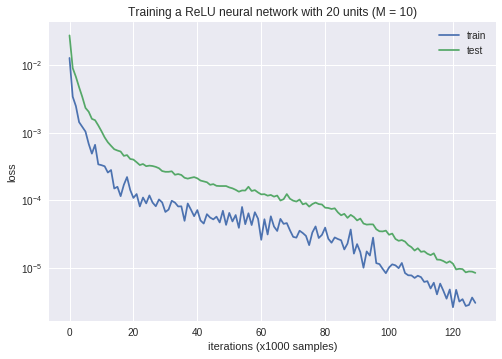

In [0]:
plt.figure()
plt.plot(train_loss)
plt.plot(test_loss)
plt.legend(['train', 'test'])
plt.xlabel('iterations (x1000 samples)')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Training a ReLU neural network with 20 units (M = 10)')

In [0]:
net = Network(5)
net.small_sphere(0.05)

test_loss = []
train_loss = []
test = net.test(X_test, Y_test)
print('init', test)
for i in range(5000):
    X, Y = gen_net.gen_sample(100)
    net.sgd_train(X, Y, tau = .1, batch = 1, epochs = 1, disp = False)
    if i%10 == 0:
        test = net.test(X_test, Y_test)
        train = net.test(X, Y)
        test_loss.append(test)
        train_loss.append(train)
        print(test)

init 0.04418097140598761
0.028489193407919798
0.009866809329397354
0.008030737116102618
0.007636411000201176
0.0074837652505326336
0.007097575316724628
0.007489793367734883
0.00613831254711495
0.006300311775399767
0.006226821029088123
0.006027712244672773
0.005939685383594867
0.005966964089433863
0.005605511050010116
0.0055932331560699594
0.005733396073950935
0.005612710783407144
0.005682012657299741
0.005631758930629644
0.005813346214549601
0.0055317490222288835
0.0055305300516081835
0.005618372757741491
0.005524587696201293
0.005407386449001121
0.0056189067234697415
0.005366603704920793
0.005428854255387702
0.005453183664674279
0.005366896339482127
0.005416389427723222
0.005606931708330888
0.005498916486055717
0.005474633215109987
0.005474037564033049
0.005710380967973675
0.005538460556327925
0.005475337910769911
0.005242412130239357
0.005304600114946234
0.005184972984242197
0.0053327550644165075
0.005270049337390806
0.0054913676499079005
0.005311991439597064
0.00532281988479732
0.00

KeyboardInterrupt: ignored

Text(0.5,1,'Training a ReLU neural network with 5 units (M = 10)')

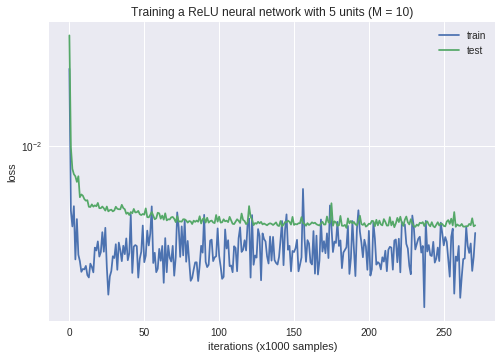

In [0]:
plt.figure()
plt.plot(train_loss)
plt.plot(test_loss)
plt.legend(['train', 'test'])
plt.xlabel('iterations (x1000 samples)')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Training a ReLU neural network with 5 units (M = 10)')

Train it using SGD

In [0]:
#net.sgd_train(X, Y, tau = 0.1, batch = 2, epochs = 1)

epoch 0 : 0.149020305273103


0.149020305273103

Make several experiments for different values of $m$

In [0]:
np.logspace(0.6, 1.6, 10, base = 10.)

array([ 3.98107171,  5.14175183,  6.64082785,  8.57695899, 11.07756851,
       14.30722989, 18.47849797, 23.86589787, 30.8239924 , 39.81071706])

In [0]:
m_range = np.logspace(0.6, 1.6, 10, base = 10.)
m_range = [int(b) for b in m_range]

rep = 5
losses = np.zeros((len(m_range), rep))

for r in tqdm.tqdm(range(rep)):
    gen_net = Network(M)
    gen_net.small_sphere(2.)
    Xt, Yt = gen_net.gen_sample(10000)
    for mi in range(len(m_range)):
        m = m_range[mi]
        net = Network(m)
        net.small_sphere(0.05)
        X, Y = gen_net.gen_sample(100000)
        train_loss = net.sgd_train(X, Y, tau = 0.2, batch = 1, epochs = 1, disp = False)
        print('train', train_loss)
        losses[mi, r] = net.test(Xt, Yt)
        print('test', losses[mi, r])
        net = []
        print(m)





  0%|          | 0/5 [00:00<?, ?it/s]

train 0.010221985103727184
test 0.010383832286606815
3
train 0.0015687730785113097
test 0.0016043711511006763
5
train 0.002957953144164164
test 0.0029268633394737577
6
train 0.0006705157179074098
test 0.0006877161830213886
8
train 0.00013206058022016248
test 0.00013012207454000092
11
train 2.7557442977344206e-05
test 2.7992715577904022e-05
14
train 1.4057563768022054e-05
test 1.3904165873687674e-05
18
train 2.6285672190129286e-05
test 2.616891176808166e-05
23
train 0.00015333386768382102
test 0.0001528309252999786
30
train 0.0001799618421056033






 20%|██        | 1/5 [04:10<16:43, 250.78s/it]

test 0.0001804032349162309
39
train 0.013287555627689929
test 0.013682383628626628
3
train 0.006791759169820847
test 0.00702585797039211
5
train 0.012267451827619241
test 0.012391897773886319
6
train 0.00025441338970154766
test 0.00026899499469578016
8
train 3.437528052705593e-05
test 3.4116960545969434e-05
11
train 3.6175800538485286e-05
test 3.525719455330933e-05
14
train 2.7204200883384955e-05
test 2.6673732877015216e-05
18
train 5.197064700532733e-05
test 5.3431763820572517e-05
23
train 0.00011908969308749045
test 0.00011957316793531916
30
train 0.00010411332398138336






 40%|████      | 2/5 [08:21<12:31, 250.61s/it]

test 0.0001081911863231655
39
train 0.015155455345401475
test 0.014878899386454125
3
train 0.004205268825034214
test 0.00424778372893119
5
train 0.0033377234988774935
test 0.0035084294007632216
6
train 0.0007988613900321198
test 0.0008176851455744249
8
train 0.00299777651315611
test 0.002972496015345557
11
train 3.2236457469014094e-05
test 3.176286548014785e-05
14
train 0.0005513448024902703
test 0.0005599572900161959
18
train 4.809924385652675e-05
test 4.861295267800727e-05
23
train 0.00010156691841655602
test 0.00010414862181704578
30
train 0.00018166231438947699






 60%|██████    | 3/5 [12:30<08:20, 250.34s/it]

test 0.00018250313095830048
39
train 0.010534519271098832
test 0.010669408060565102
3
train 0.00417067145675745
test 0.004149182474823742
5
train 0.01373165681112005
test 0.014096316472232655
6
train 0.0004175197740190704
test 0.0004229243393109298
8
train 0.0002816051075111442
test 0.00027638228989379006
11
train 4.8060771270047785e-05
test 4.81960976477003e-05
14
train 4.448215949343884e-05
test 4.505696510932546e-05
18
train 5.4015559407144024e-05
test 5.670707768989536e-05
23
train 9.48352486762616e-05
test 9.634032916601312e-05
30
train 0.0002231962481494821






 80%|████████  | 4/5 [16:41<04:10, 250.35s/it]

test 0.00023136904094066385
39
train 0.005708033050590818
test 0.005806784820279338
3
train 0.0057112110852300555
test 0.005792185505365029
5
train 0.0024910284324290814
test 0.0025565470067788285
6
train 0.0025187317721169257
test 0.002651821189454819
8
train 3.299929663889436e-05
test 3.354706976586918e-05
11
train 6.132324563305155e-05
test 6.17976566261042e-05
14
train 8.538069870991978e-06
test 8.590229861606837e-06
18
train 2.1564428871922194e-05
test 2.196236329512851e-05
23
train 5.207094817310592e-05
test 5.323775820136678e-05
30
train 7.605558818607808e-05






100%|██████████| 5/5 [20:51<00:00, 250.24s/it]





test 7.910045111434615e-05
39


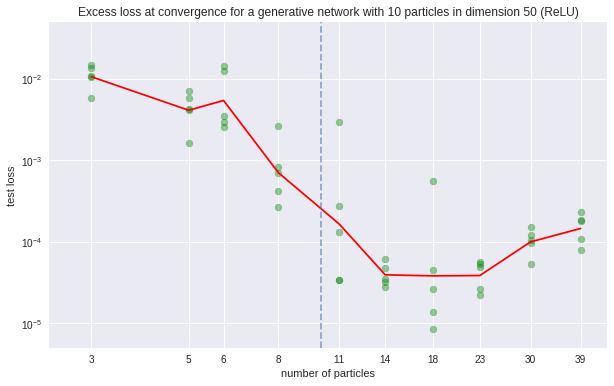

In [0]:
plt.figure(figsize = (10, 6))
for i in range(rep):
    plt.scatter(m_range, losses[:, i], c='g', alpha = 0.4)
plt.plot(m_range, np.exp(np.mean(np.log(losses), axis = 1)), c='r')
plt.yscale('log')
plt.xscale('log')
#plt.xlim((2.8, 105))
plt.ylim((5e-6, 0.05))
plt.xticks(m_range, m_range)
plt.ylabel('test loss')
plt.axvline(x=10, linestyle = '--', alpha = 0.6)
plt.xlabel('number of particles')
plt.title('Excess loss at convergence for a generative network with 10 particles in dimension 50 (ReLU)')
plt.show()

Write batch train function, reduce d, "use fresh samples at each iteration", sampling at test time